# LEP vs shower time
This is a tricky case.  LEP is often 20 minutes after shower, but only after a certain time (8pm ish?).  Looking for ways to discover this 2D relationship, in a way I can apply to other data.  Visualisations, ML, etc.

In [67]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [69]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [125]:
col1 = 'events:shower:lastSSM'
col2 = 'circadian:combined:entries:LEP:datetimeSSM'
c1 = 'shower'
c2 = 'LEP'

columns_to_select = [col1, col2]

df = day_data.copy()[columns_to_select]
df.index = day_data['dayAndNightOf']
import notebooks.Util.Time as Time
reload(Time)
df = Time.convert_cols_to_hours(df)


df[c1] = df[col1.replace(':lastSSM', ':last')]
df[c2] = df[col2.replace(':datetimeSSM', ':datetime')]
df.drop(columns=[col1.replace(':lastSSM', ':last'), col2.replace(':datetimeSSM', ':datetime')], inplace=True)

# Circadian data just gets better here. As I'm doing morning walks.
df = df[df.index >= '2024-08-14']
df = df[df[c1].notna() & df[c2].notna()]
df['Diff'] = df[c1] - df[c2]


df.head()

,shower,LEP,Diff
dayAndNightOf,,,
2024-08-18,14.766667,22.366667,-7.600000
2024-08-26,15.416667,21.200000,-5.783333
2024-09-15,18.250000,21.400000,-3.150000
2024-09-18,21.166667,21.933333,-0.766667
2024-09-28,18.833333,21.866667,-3.033333


# Simple correlations

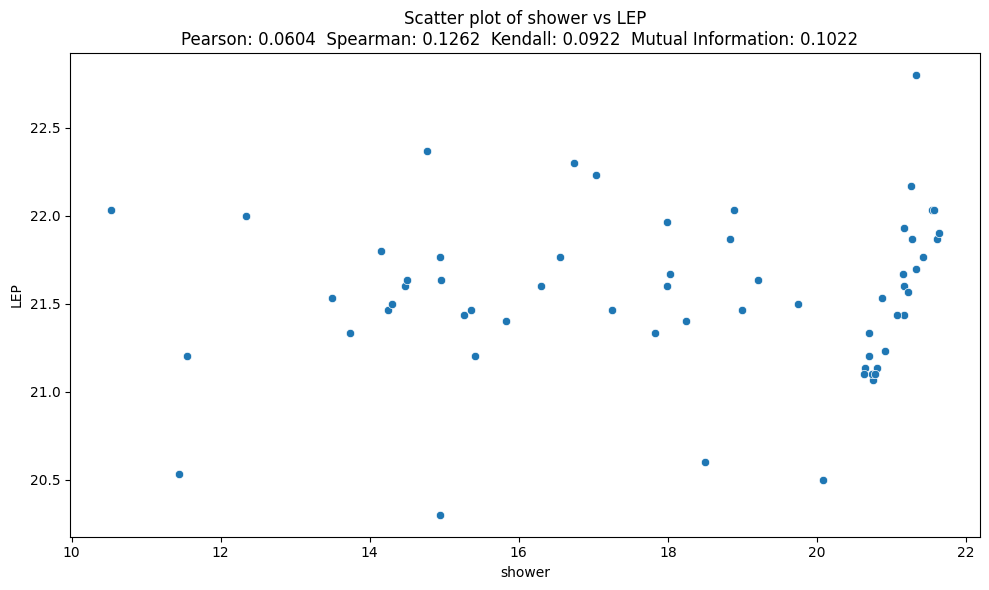

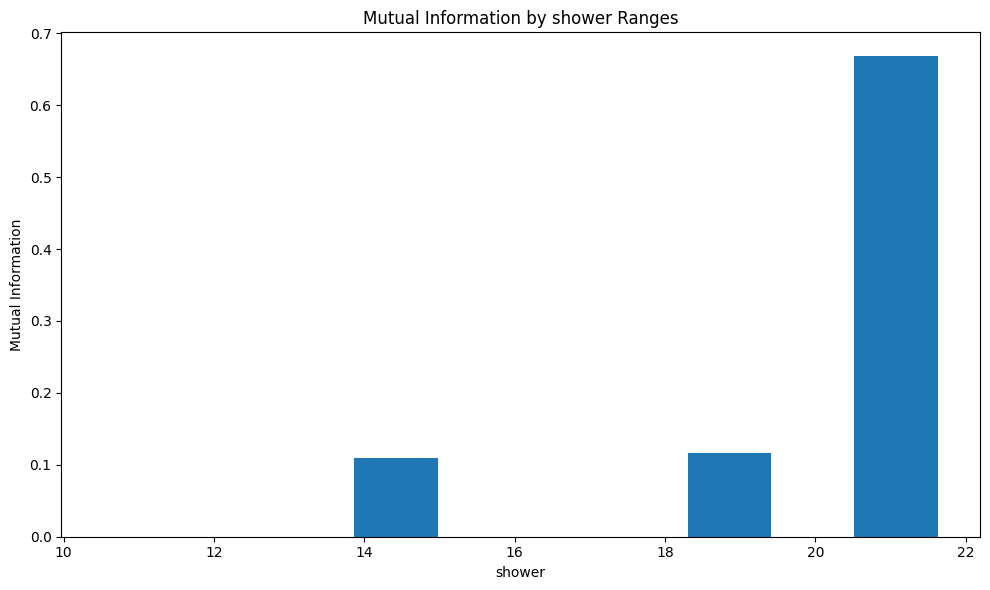

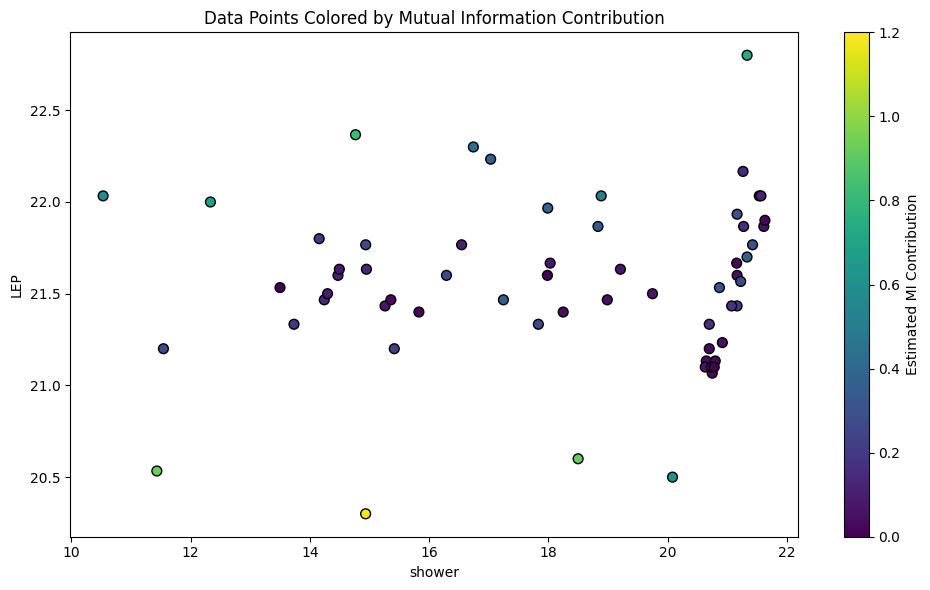

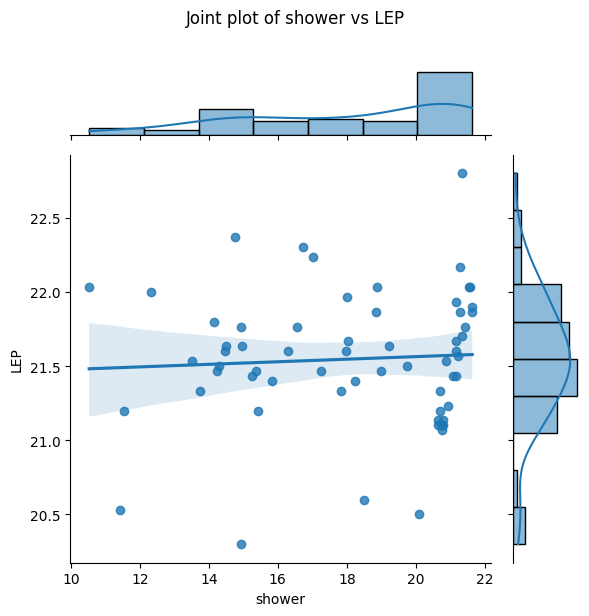

Pearson correlation: 0.0604, p-value: 0.6408
Spearman correlation: 0.1262, p-value: 0.3285
Kendall correlation: 0.0922, p-value: 0.2956
Mutual Information: 0.1022


In [160]:
import stats_two_variables
reload(stats_two_variables)

results = stats_two_variables.calculate_correlations(df, c1, c2)
stats_two_variables.visualize_scatter(df, c1, c2, results)
stats_two_variables.visualize_joint_plot(df, c1, c2)
stats_two_variables.print_correlation_results(results)

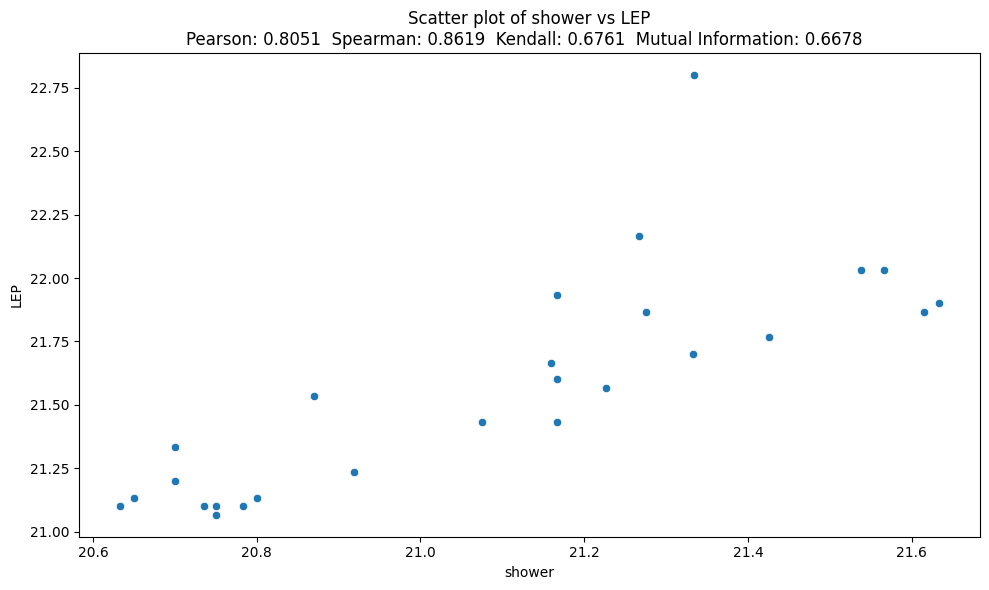

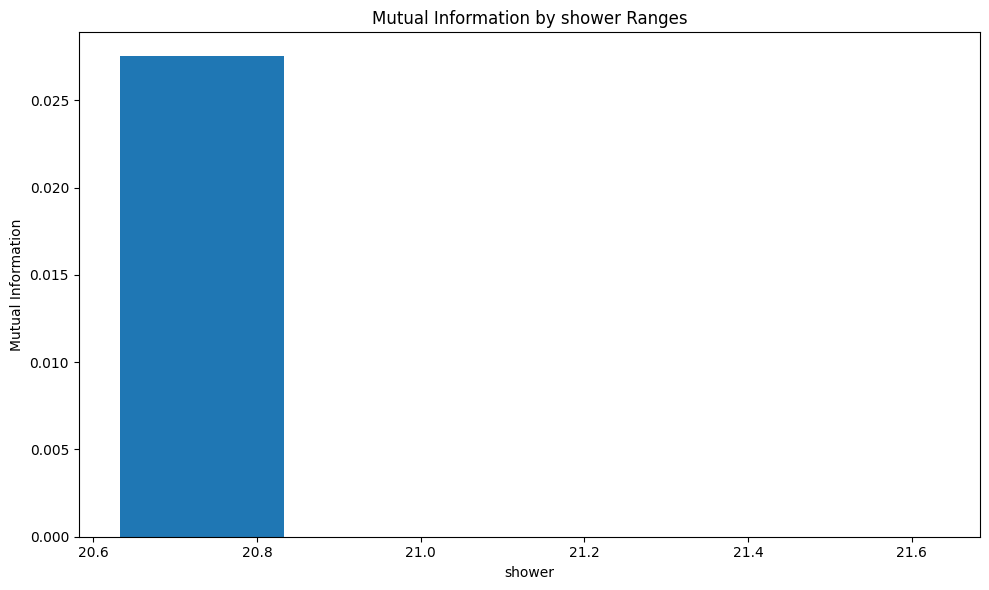

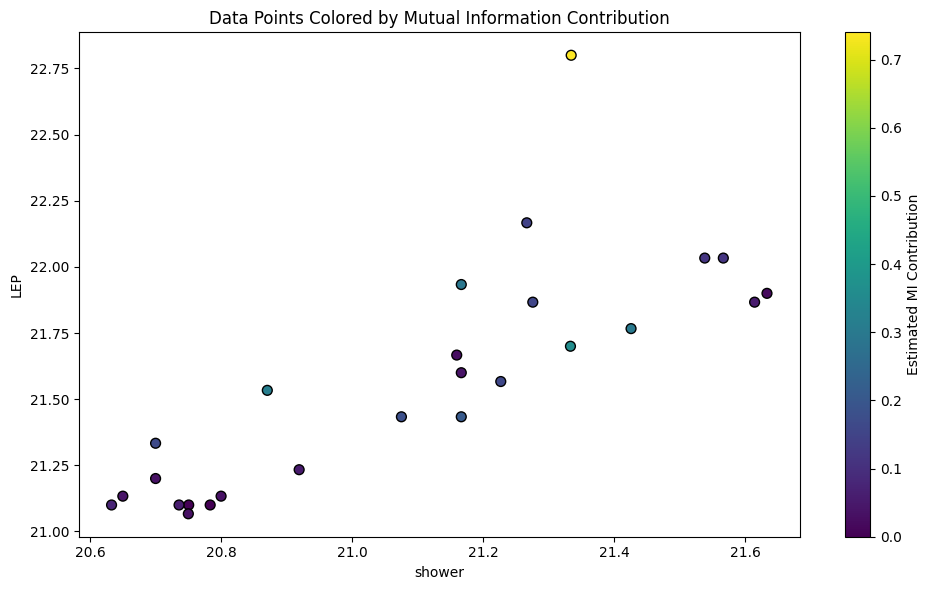

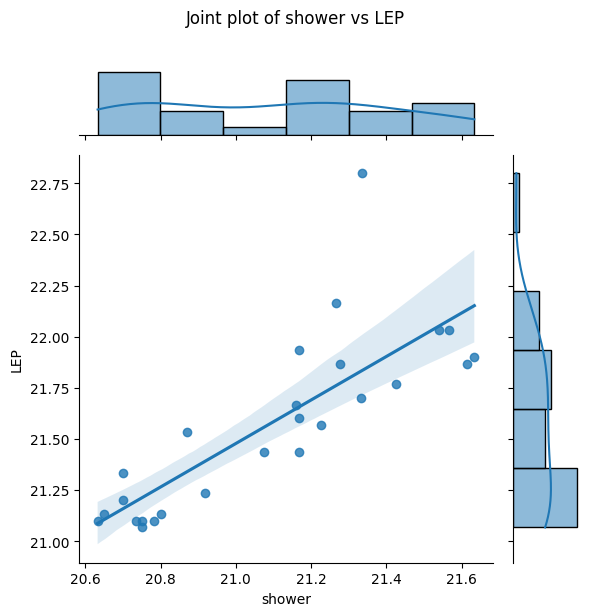

{'Pearson': {'correlation': np.float64(0.8050694273924396),
  'p_value': np.float64(7.067983826442344e-07)},
 'Spearman': {'correlation': np.float64(0.8619458046243965),
  'p_value': np.float64(1.5360984557625803e-08)},
 'Kendall': {'correlation': np.float64(0.6761307172968649),
  'p_value': np.float64(1.9468068129776805e-06)},
 'Mutual Information': {'score': np.float64(0.6678390802848622)}}

In [161]:
# After 8pm
df_after_8 = df[df['shower'] >= 20.25]
results = stats_two_variables.calculate_correlations(df_after_8, c1, c2)
stats_two_variables.visualize_scatter(df_after_8, c1, c2, results)
stats_two_variables.visualize_joint_plot(df_after_8, c1, c2)
results

# Look for horizontal threshold where linear model works better
Works great for shower vs LEP, probbly not for others

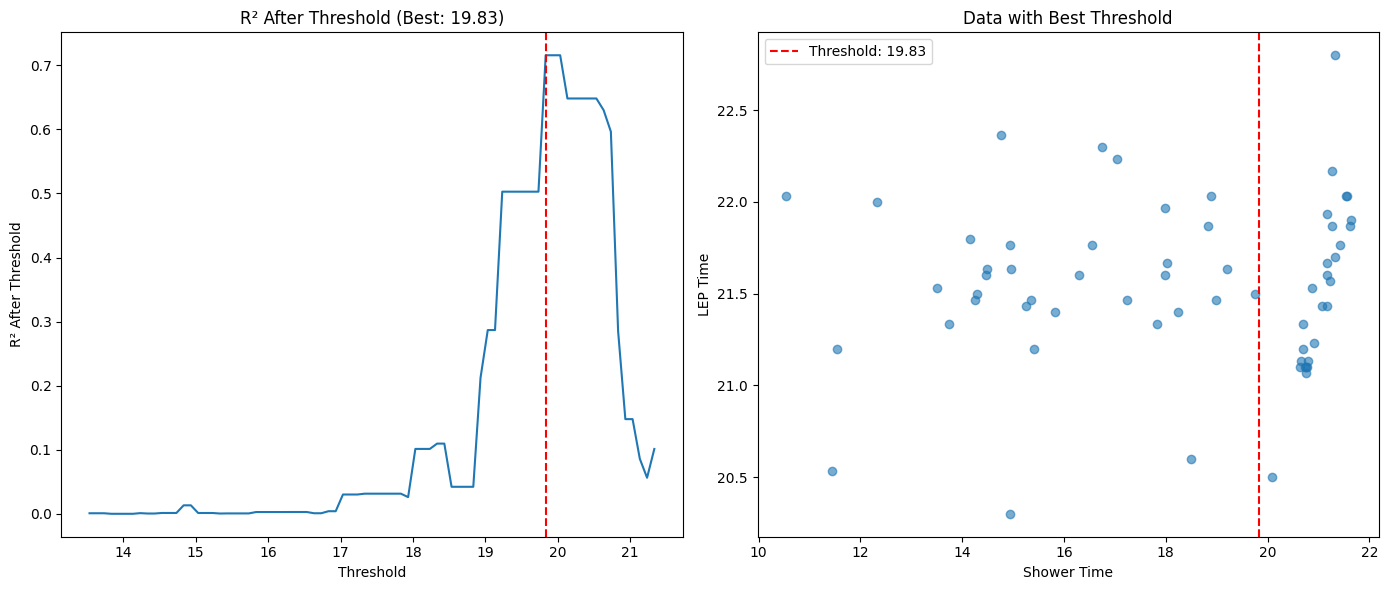

(np.float64(19.8333333333333),
     threshold  points_after  points_before  r2_after  mean_after  std_after
 0   13.533333            57              5  0.001157   21.554971   0.437897
 1   13.633333            57              5  0.001157   21.554971   0.437897
 2   13.733333            57              5  0.001157   21.554971   0.437897
 3   13.833333            56              6  0.000315   21.558929   0.440778
 4   13.933333            56              6  0.000315   21.558929   0.440778
 ..        ...           ...            ...       ...         ...        ...
 74  20.933333            15             47  0.147979   21.851111   0.329953
 75  21.033333            15             47  0.147979   21.851111   0.329953
 76  21.133333            14             48  0.086041   21.880952   0.321384
 77  21.233333             9             53  0.056551   22.014815   0.308765
 78  21.333333             7             55  0.101426   22.014286   0.340801
 
 [79 rows x 6 columns])

In [162]:
import stats_two_variables
reload(stats_two_variables)

X = df[c1].values.reshape(-1, 1)
y = df[c2].values

stats_two_variables.find_optimal_threshold(X, y)

# Machine learning

Outlier removal: removed 6 points (9.7%), R² improved from 0.2630 to 0.4930
Decision Tree Rules:
|--- shower <= 21.25
|   |--- shower <= 19.92
|   |   |--- value: [21.64]
|   |--- shower >  19.92
|   |   |--- value: [21.25]
|--- shower >  21.25
|   |--- shower <= 21.38
|   |   |--- value: [22.28]
|   |--- shower >  21.38
|   |   |--- value: [21.92]



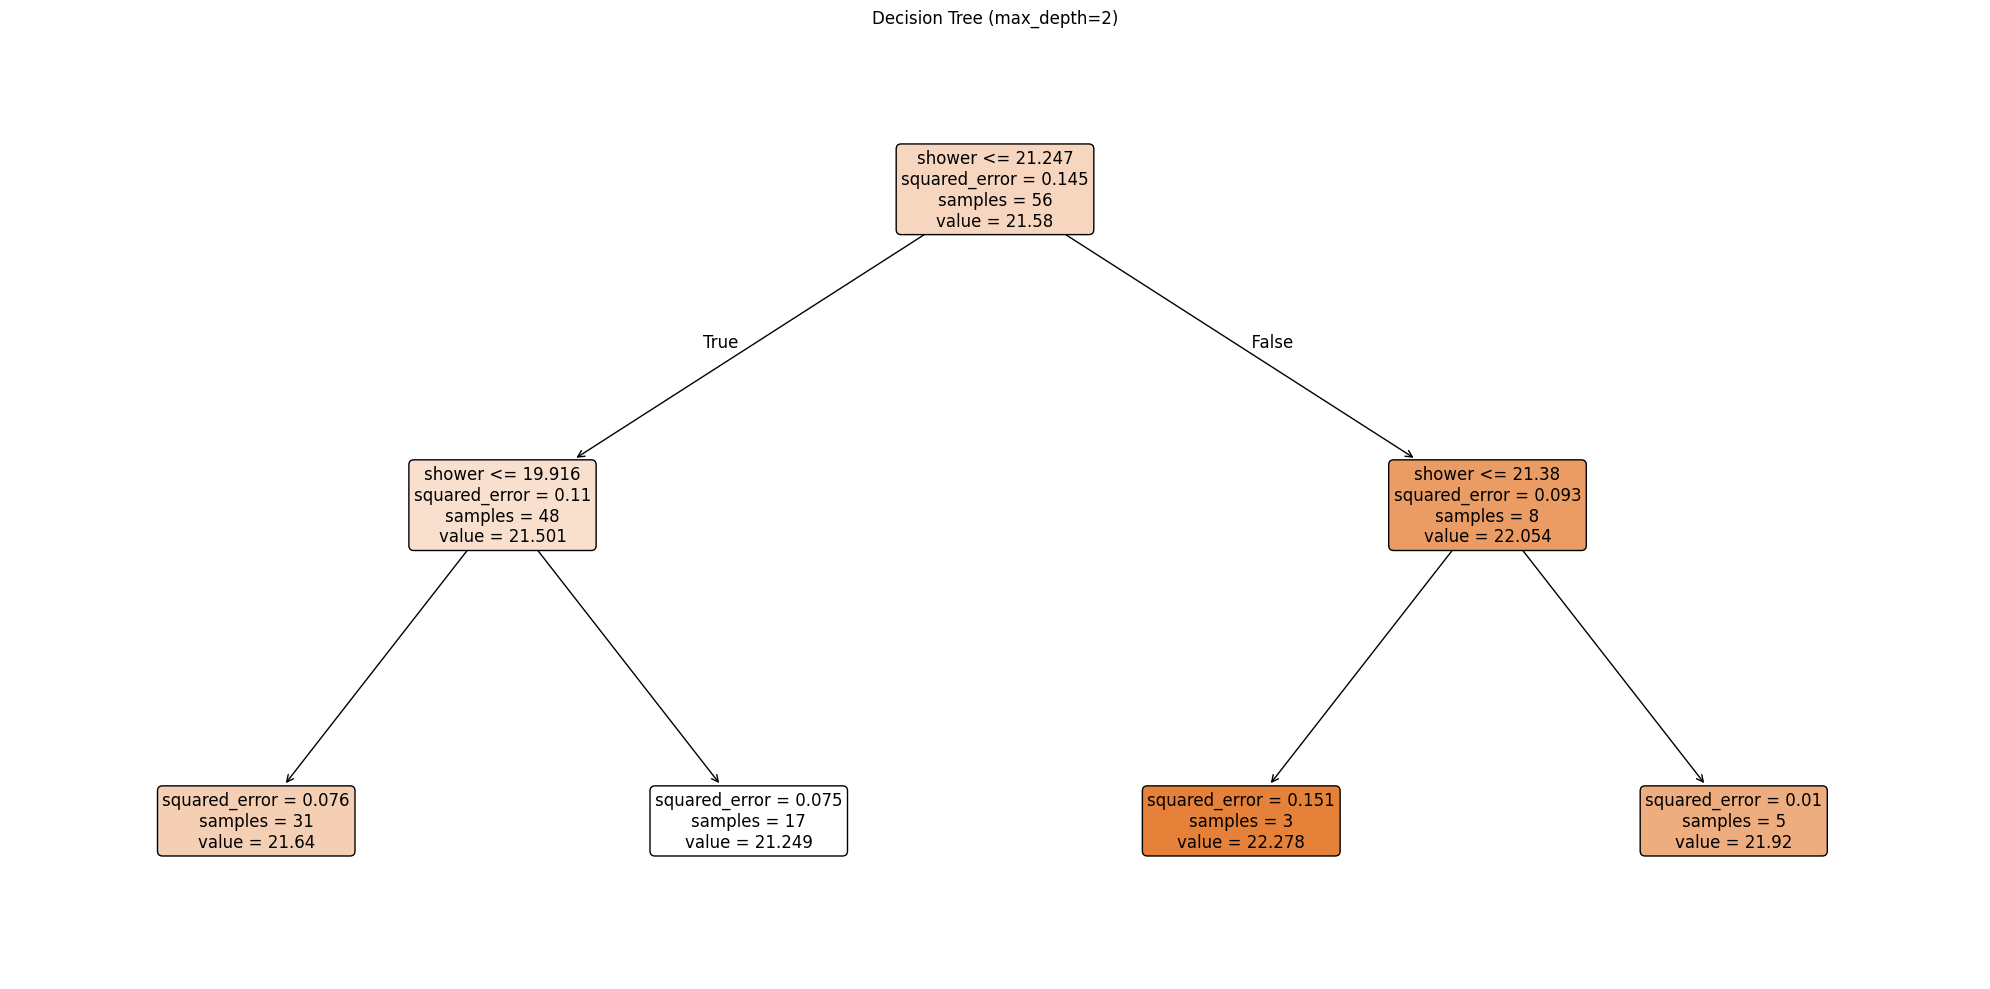

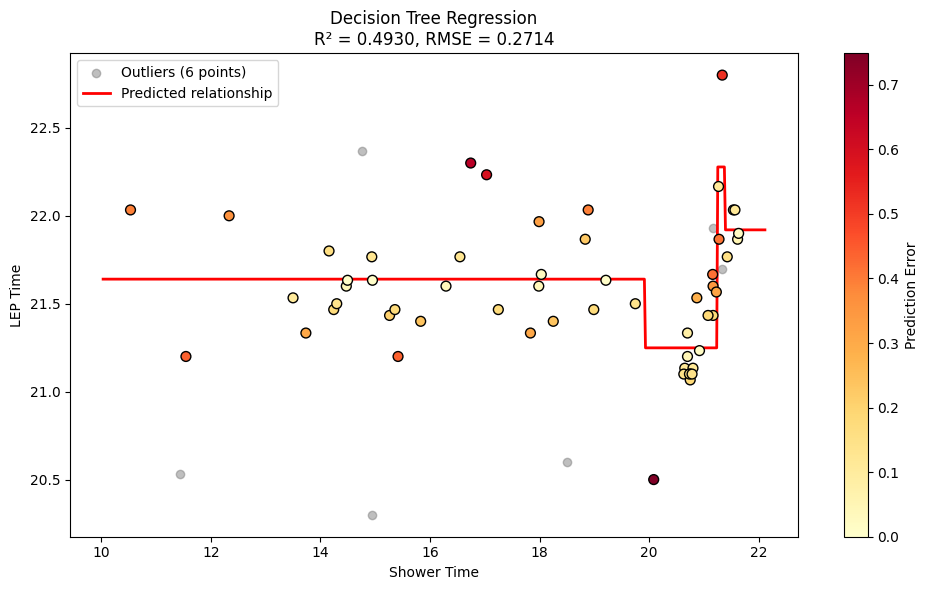

Using 2D clustering on both shower and LEP
Finding optimal subsets for Decision Tree...

K-Means - Cluster 0:
  Size: 14 points
  shower range: 16.29 to 19.21 (std=0.92)
  LEP range: 21.33 to 22.30 (std=0.29)
  CV R² Score: -11.3629
  Spearman's correlation: -0.1344
  Mutual Information: 0.0022

K-Means - Cluster 1:
  Size: 26 points
  shower range: 19.75 to 21.63 (std=0.44)
  LEP range: 20.50 to 22.80 (std=0.46)
  CV R² Score: -2.5396
  Spearman's correlation: 0.8325
  Mutual Information: 0.6915

K-Means - Cluster 2:
  Size: 16 points
  shower range: 10.53 to 15.83 (std=1.42)
  LEP range: 21.20 to 22.03 (std=0.24)
  CV R² Score: -5.0788
  Spearman's correlation: -0.3508
  Mutual Information: 0.0667

DBSCAN - Cluster 0:
  Size: 14 points
  shower range: 13.50 to 16.29 (std=0.77)
  LEP range: 21.20 to 21.80 (std=0.16)
  CV R² Score: -25.8203
  Spearman's correlation: -0.2073
  Mutual Information: 0.0423

DBSCAN - Cluster 2:
  Size: 24 points
  shower range: 20.63 to 21.63 (std=0.33)
  L

c:\dev\Brainwave-Processor\notebooks\Stats\stats_two_variables.py:1284: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.


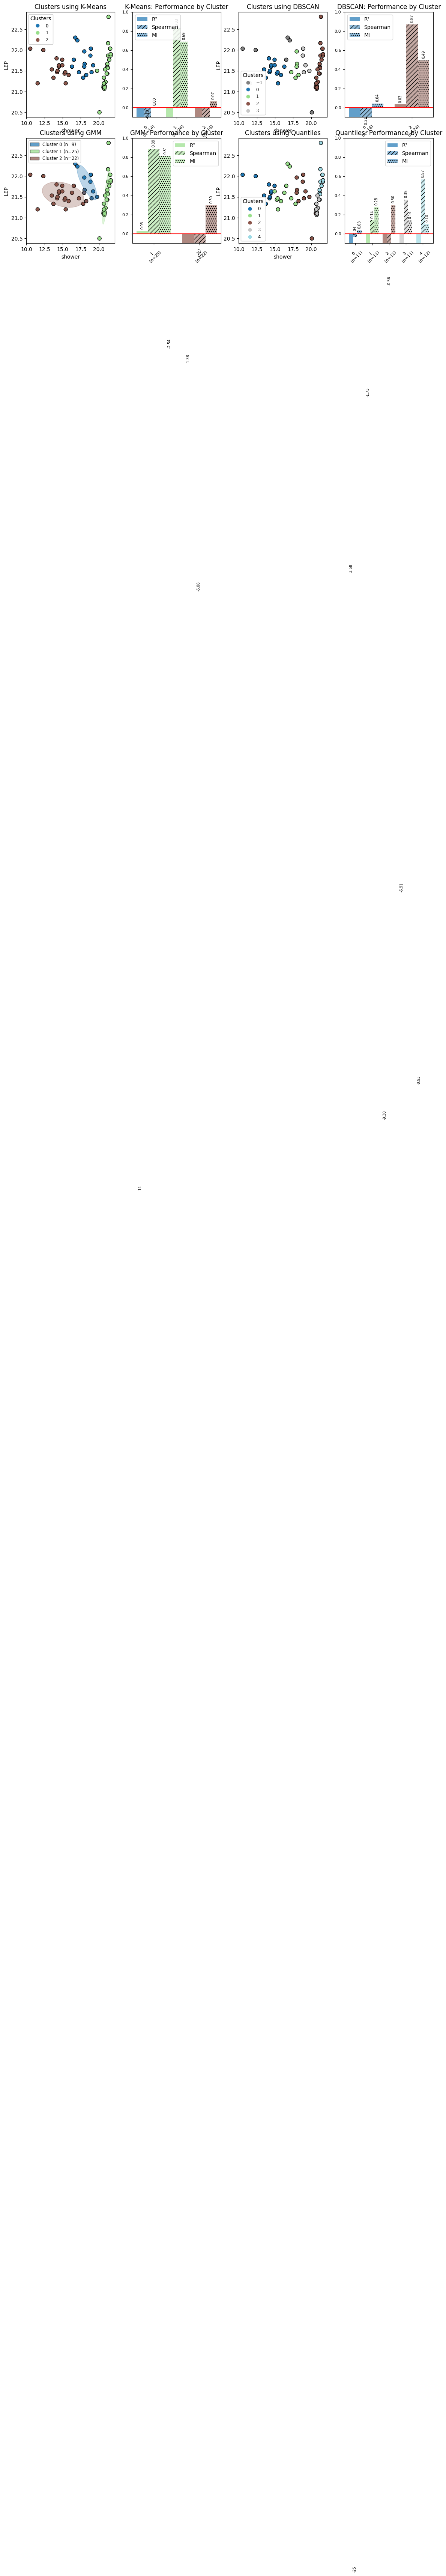

Debugging information saved to 'cluster_debug_info.json'


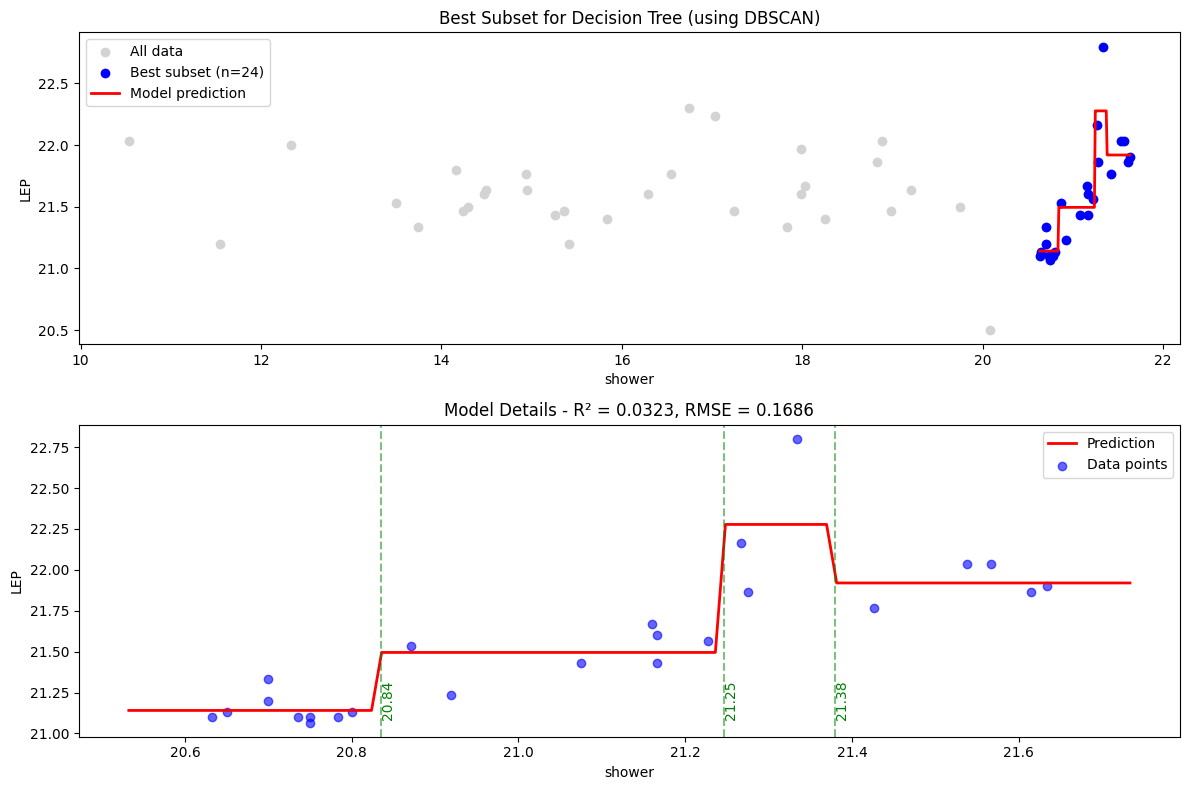


Best subset found using DBSCAN:
R² score: 0.0323
RMSE: 0.1686
Spearman's correlation: 0.8702
Mutual Information: 0.4930
Subset size: 24 points (42.9% of data)
shower range: 20.63 to 21.63
Decision Tree Regression Results:
R² score: 0.4930
RMSE: 0.2714
Outliers removed: 6 points (9.7%)


In [173]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_decision_tree_regressor(df, c1, c2, max_depth=2)

Outlier removal: removed 1 points (1.6%), R² improved from 0.8189 to 0.9796


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\skle

Best Gaussian Process Kernel: Matern
Optimized kernel parameters: 0.964**2 * Matern(length_scale=1e-05, nu=1.5)


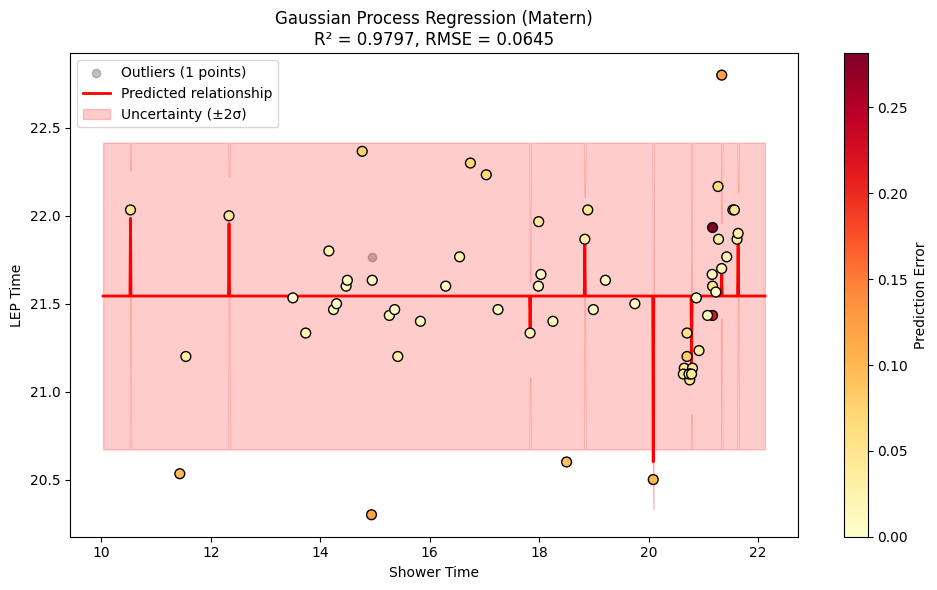

Using 2D clustering on both shower and LEP
Finding optimal subsets for Gaussian Process...

K-Means - Cluster 0:
  Size: 15 points
  shower range: 16.29 to 19.21 (std=0.90)
  LEP range: 20.60 to 22.30 (std=0.40)
  CV R² Score: -1.5284
  Spearman's correlation: -0.1807
  Mutual Information: 0.1035

K-Means - Cluster 1:
  Size: 28 points
  shower range: 19.75 to 21.63 (std=0.43)
  LEP range: 20.50 to 22.80 (std=0.45)
  CV R² Score: -0.3503
  Spearman's correlation: 0.8369
  Mutual Information: 0.6056

K-Means - Cluster 2:
  Size: 18 points
  shower range: 10.53 to 15.83 (std=1.48)
  LEP range: 20.30 to 22.37 (std=0.47)
  CV R² Score: -0.9872
  Spearman's correlation: -0.1778
  Mutual Information: 0.0785

DBSCAN - Cluster 0:
  Size: 14 points
  shower range: 13.50 to 16.29 (std=0.77)
  LEP range: 21.20 to 22.37 (std=0.26)
  CV R² Score: -1.1829
  Spearman's correlation: -0.1852
  Mutual Information: 0.0888

DBSCAN - Cluster 1:
  Size: 11 points
  shower range: 17.25 to 19.75 (std=0.70)
  

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\g

  CV R² Score: -2.8376
  Spearman's correlation: 0.8619
  Mutual Information: 0.9112

GMM - Cluster 0:
  Size: 14 points
  shower range: 16.74 to 19.75 (std=0.83)
  LEP range: 20.60 to 22.30 (std=0.42)
  CV R² Score: -3.7378
  Spearman's correlation: -0.2420
  Mutual Information: 0.0154

GMM - Cluster 1:
  Size: 27 points
  shower range: 20.08 to 21.63 (std=0.37)
  LEP range: 20.50 to 22.80 (std=0.46)
  CV R² Score: -0.0130
  Spearman's correlation: 0.8768
  Mutual Information: 0.7589

GMM - Cluster 2:
  Size: 20 points
  shower range: 10.53 to 16.55 (std=1.59)
  LEP range: 20.30 to 22.37 (std=0.45)
  CV R² Score: -1.1899
  Spearman's correlation: -0.0467
  Mutual Information: 0.2854

Quantiles - Cluster 0:
  Size: 12 points
  shower range: 10.53 to 14.77 (std=1.38)
  LEP range: 20.53 to 22.37 (std=0.44)
  CV R² Score: -3.4073
  Spearman's correlation: 0.2937
  Mutual Information: 0.0801

Quantiles - Cluster 1:
  Size: 12 points
  shower range: 14.94 to 17.83 (std=0.93)
  LEP range: 20

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  CV R² Score: -11.6725
  Spearman's correlation: 0.5053
  Mutual Information: 0.1416

Quantiles - Cluster 4:
  Size: 13 points
  shower range: 21.17 to 21.63 (std=0.17)
  LEP range: 21.43 to 22.80 (std=0.33)
  CV R² Score: -2.4393
  Spearman's correlation: 0.4183
  Mutual Information: 0.0833


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\dev\Brainwave-Processor\notebooks\Stats\stats_two_variables.py:1284: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.


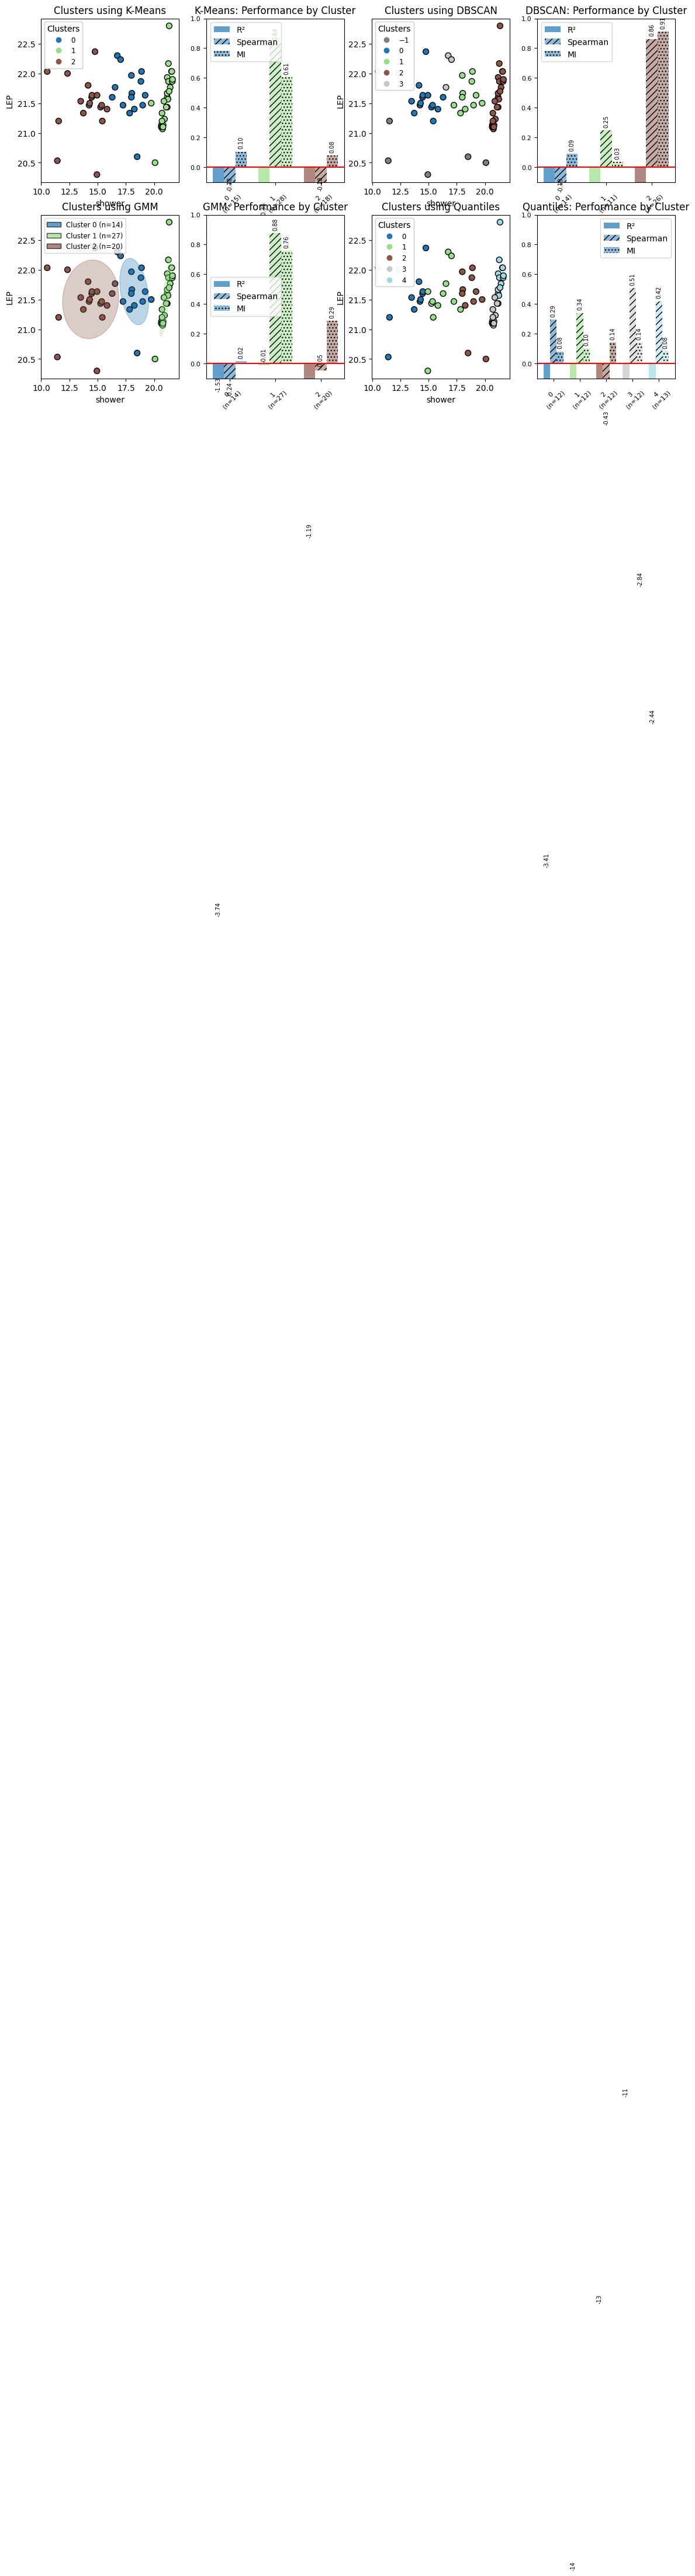

Debugging information saved to 'cluster_debug_info.json'


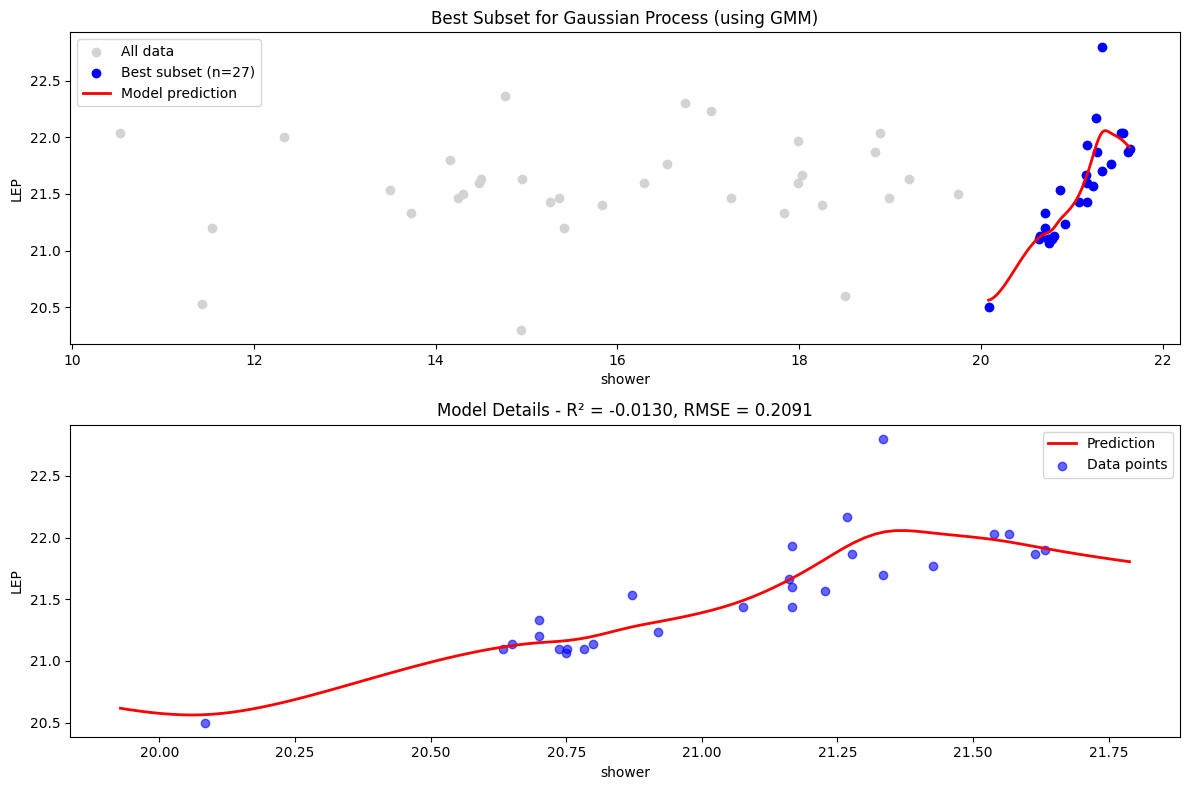


Best subset found using GMM:
R² score: -0.0130
RMSE: 0.2091
Spearman's correlation: 0.8768
Mutual Information: 0.7589
Subset size: 27 points (44.3% of data)
shower range: 20.08 to 21.63
Gaussian Process Regression Results (Kernel: Matern):
R² score: 0.9797
RMSE: 0.0645
Outliers removed: 1 points (1.6%)


In [164]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_gaussian_process_regressor(df, c1, c2)

Outlier removal: removed 6 points (9.7%), R² improved from 0.1909 to 0.3431


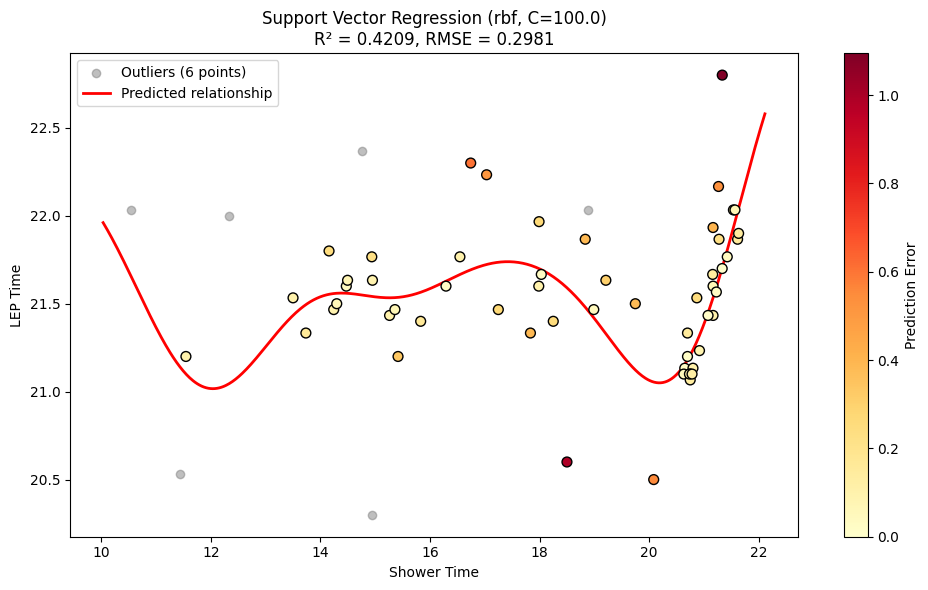

Using 2D clustering on both shower and LEP
Finding optimal subsets for SVR...

K-Means - Cluster 0:
  Size: 14 points
  shower range: 11.54 to 15.83 (std=1.03)
  LEP range: 21.20 to 21.80 (std=0.18)
  CV R² Score: -6.3119
  Spearman's correlation: -0.0882
  Mutual Information: 0.0000

K-Means - Cluster 1:
  Size: 28 points
  shower range: 19.75 to 21.63 (std=0.43)
  LEP range: 20.50 to 22.80 (std=0.45)
  CV R² Score: -0.0455
  Spearman's correlation: 0.8369
  Mutual Information: 0.6056

K-Means - Cluster 2:
  Size: 14 points
  shower range: 16.29 to 19.21 (std=0.89)
  LEP range: 20.60 to 22.30 (std=0.40)
  CV R² Score: -10.7641
  Spearman's correlation: -0.2930
  Mutual Information: 0.1104

DBSCAN - Cluster 0:
  Size: 14 points
  shower range: 13.50 to 16.29 (std=0.77)
  LEP range: 21.20 to 21.80 (std=0.16)
  CV R² Score: -20.4470
  Spearman's correlation: -0.2073
  Mutual Information: 0.0423

DBSCAN - Cluster 2:
  Size: 26 points
  shower range: 20.63 to 21.63 (std=0.32)
  LEP range: 

c:\dev\Brainwave-Processor\notebooks\Stats\stats_two_variables.py:1284: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.


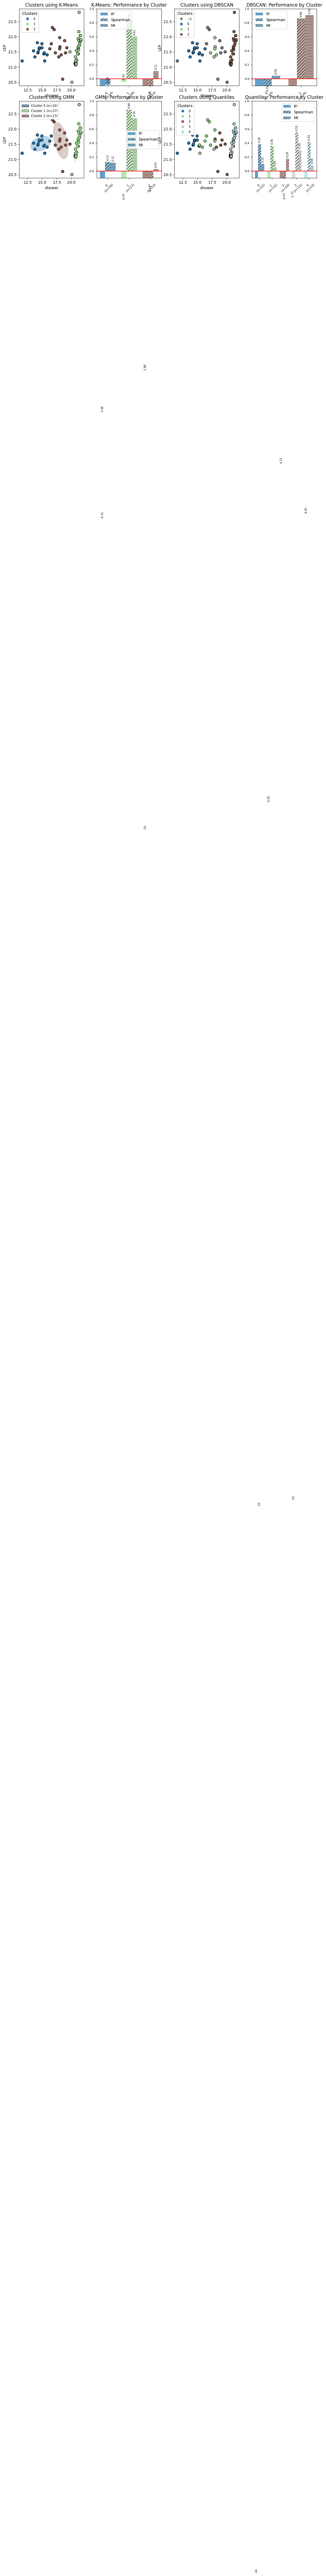

Debugging information saved to 'cluster_debug_info.json'


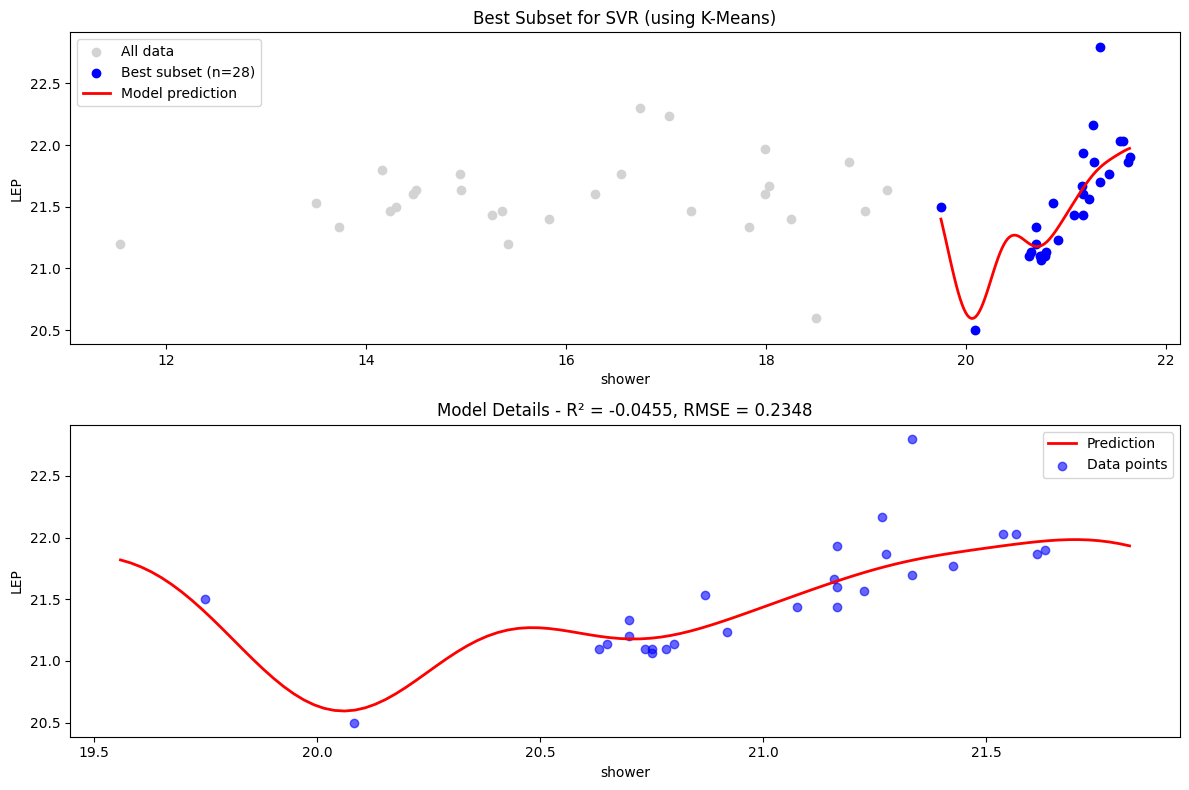


Best subset found using K-Means:
R² score: -0.0455
RMSE: 0.2348
Spearman's correlation: 0.8369
Mutual Information: 0.6056
Subset size: 28 points (50.0% of data)
shower range: 19.75 to 21.63
SVR Results (kernel=rbf, C=100.0):
R² score: 0.4209
RMSE: 0.2981
Outliers removed: 6 points (9.7%)


In [165]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_svr(df, c1, c2)

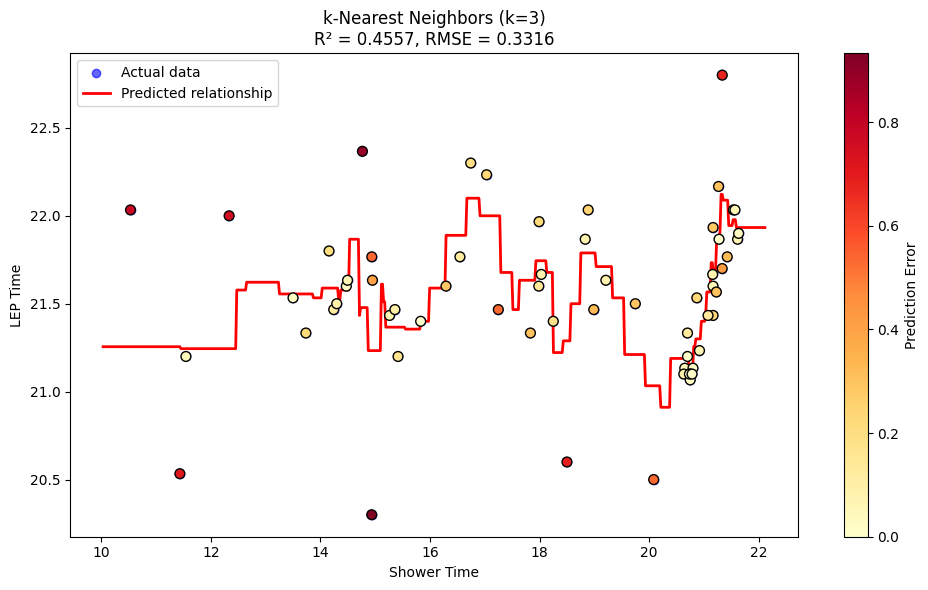

Using 2D clustering on both shower and LEP
Finding optimal subsets for k-NN...

K-Means - Cluster 0:
  Size: 19 points
  shower range: 10.53 to 15.83 (std=1.46)
  LEP range: 20.30 to 22.37 (std=0.46)
  CV R² Score: -1.0793
  Spearman's correlation: -0.1563
  Mutual Information: 0.0638

K-Means - Cluster 1:
  Size: 28 points
  shower range: 19.75 to 21.63 (std=0.43)
  LEP range: 20.50 to 22.80 (std=0.45)
  CV R² Score: 0.1321
  Spearman's correlation: 0.8369
  Mutual Information: 0.6056

K-Means - Cluster 2:
  Size: 15 points
  shower range: 16.29 to 19.21 (std=0.90)
  LEP range: 20.60 to 22.30 (std=0.40)
  CV R² Score: -2.0607
  Spearman's correlation: -0.1807
  Mutual Information: 0.1035

DBSCAN - Cluster 0:
  Size: 15 points
  shower range: 13.50 to 16.29 (std=0.74)
  LEP range: 21.20 to 22.37 (std=0.26)
  CV R² Score: -0.9828
  Spearman's correlation: -0.1862
  Mutual Information: 0.1422

DBSCAN - Cluster 1:
  Size: 11 points
  shower range: 17.25 to 19.75 (std=0.70)
  LEP range: 21

c:\dev\Brainwave-Processor\notebooks\Stats\stats_two_variables.py:1284: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.


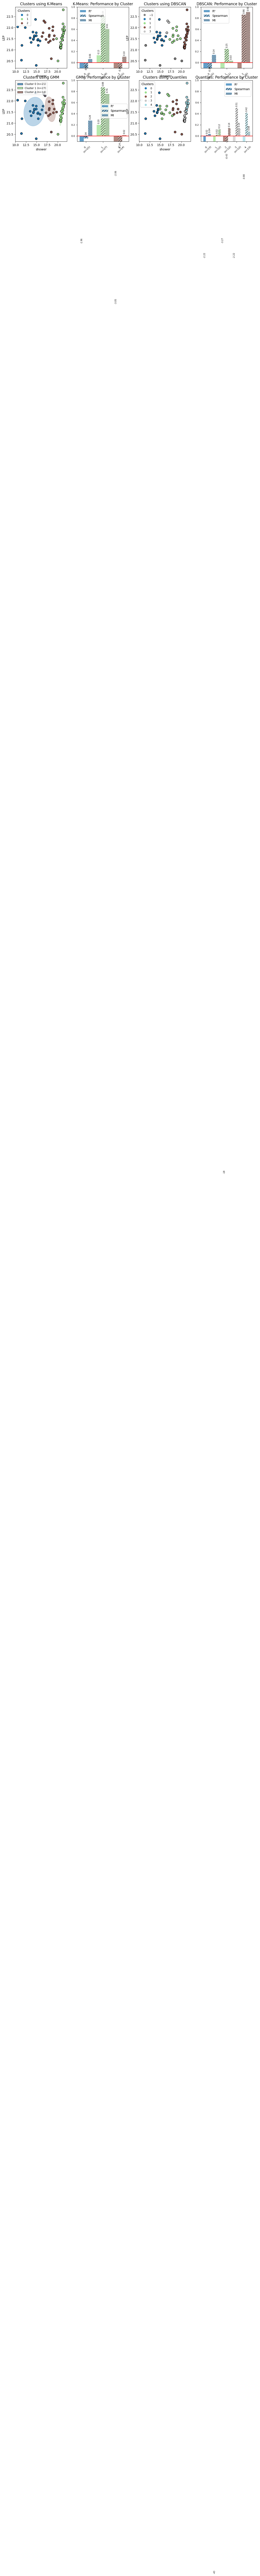

Debugging information saved to 'cluster_debug_info.json'


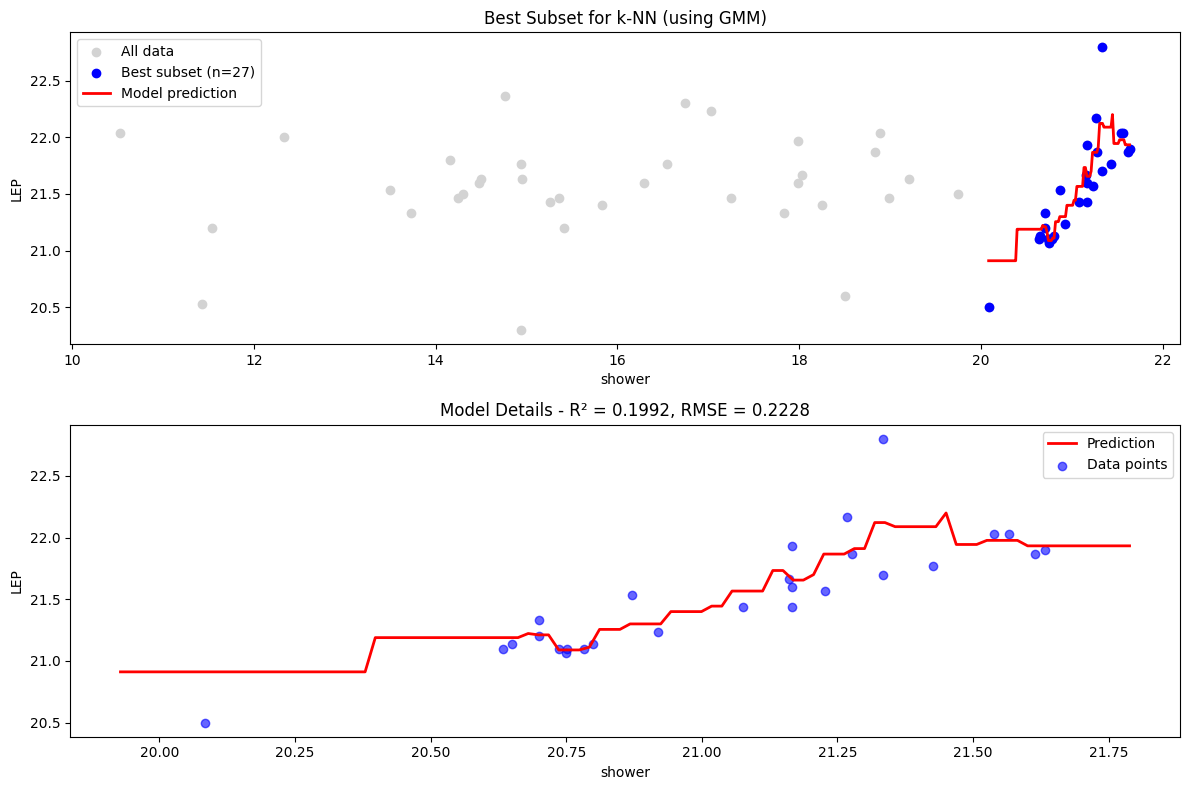


Best subset found using GMM:
R² score: 0.1992
RMSE: 0.2228
Spearman's correlation: 0.8768
Mutual Information: 0.7589
Subset size: 27 points (43.5% of data)
shower range: 20.08 to 21.63
k-NN Regression Results (k=3):
R² score: 0.4557
RMSE: 0.3316


In [166]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_knn_regressor(df, c1, c2)




Random Forest Feature Importance: 1.0000


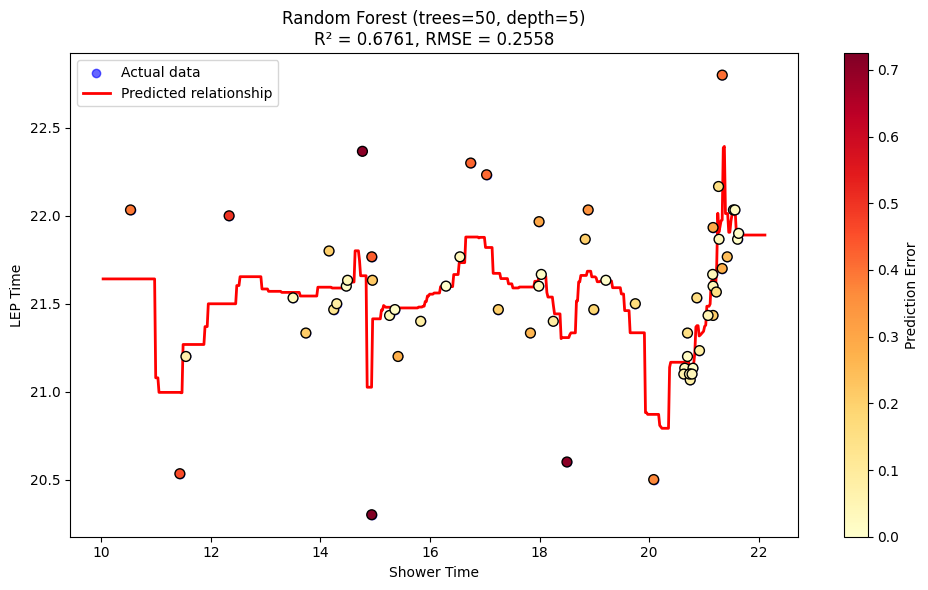

Using 2D clustering on both shower and LEP
Finding optimal subsets for Random Forest...

K-Means - Cluster 0:
  Size: 19 points
  shower range: 10.53 to 15.83 (std=1.46)
  LEP range: 20.30 to 22.37 (std=0.46)
  CV R² Score: -4.5242
  Spearman's correlation: -0.1563
  Mutual Information: 0.0638

K-Means - Cluster 1:
  Size: 28 points
  shower range: 19.75 to 21.63 (std=0.43)
  LEP range: 20.50 to 22.80 (std=0.45)
  CV R² Score: -0.2194
  Spearman's correlation: 0.8369
  Mutual Information: 0.6056

K-Means - Cluster 2:
  Size: 15 points
  shower range: 16.29 to 19.21 (std=0.90)
  LEP range: 20.60 to 22.30 (std=0.40)
  CV R² Score: -3.0405
  Spearman's correlation: -0.1807
  Mutual Information: 0.1035

DBSCAN - Cluster 0:
  Size: 15 points
  shower range: 13.50 to 16.29 (std=0.74)
  LEP range: 21.20 to 22.37 (std=0.26)
  CV R² Score: -0.7972
  Spearman's correlation: -0.1862
  Mutual Information: 0.1422

DBSCAN - Cluster 1:
  Size: 11 points
  shower range: 17.25 to 19.75 (std=0.70)
  LEP

c:\dev\Brainwave-Processor\notebooks\Stats\stats_two_variables.py:1284: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.


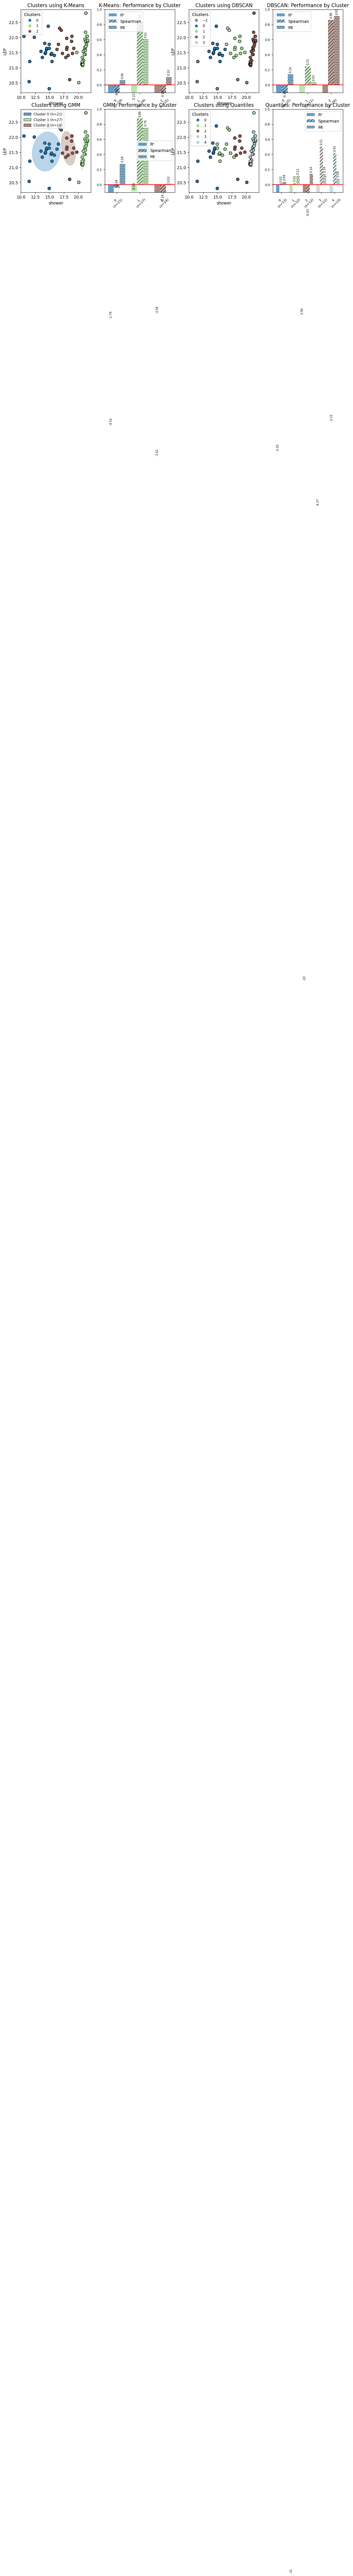

Debugging information saved to 'cluster_debug_info.json'


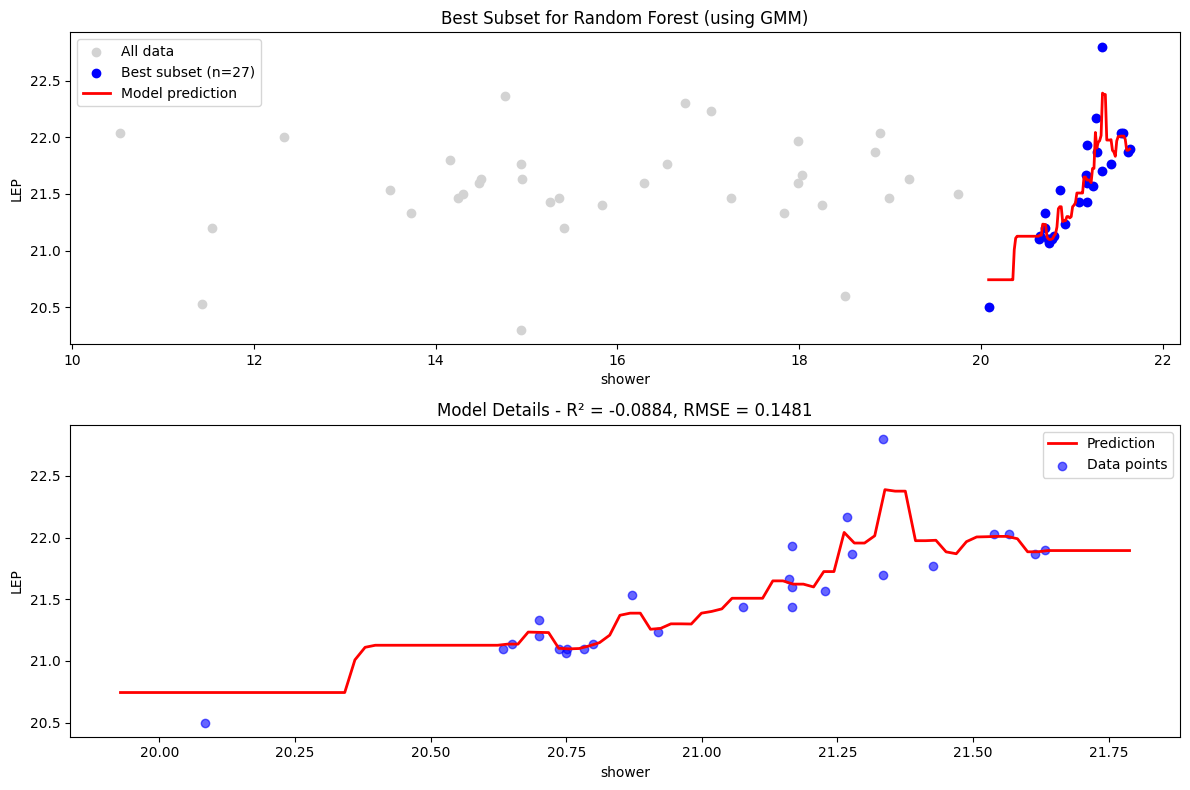


Best subset found using GMM:
R² score: -0.0884
RMSE: 0.1481
Spearman's correlation: 0.8768
Mutual Information: 0.7589
Subset size: 27 points (43.5% of data)
shower range: 20.08 to 21.63
Random Forest Regression Results (trees=50, depth=5):
R² score: 0.6761
RMSE: 0.2558


In [167]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_random_forest_regressor(df, c1, c2)


In [168]:
from pysr import PySRRegressor

df2 = df.copy().drop(columns=['Diff'])
df2.columns = df2.columns.str.replace(':', '_')
X = df2.drop(columns=['LEP'])
y = df2['LEP']

model = PySRRegressor(niterations=30, progress=True)
model.fit(X, y)


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.020e-01  1.594e+01  y = 21.547
5           2.013e-01  9.147e-04  y = 21.39 - (shower * -0.0086723)
7           1.984e-01  7.235e-03  y = (-0.51432 / (shower + -23.525)) - -21.413
9           1.826e-01  4.147e-02  y = (-1.261 / ((shower + -11.314) * shower)) - -21.583
11          1.758e-01  1.897e-02  y = (-1.7983 / ((shower + -21.931) * (shower + -11.983))) ...
                                      - -21.39
───────────────────────────────────────────────────────────────────────────────────────────────────


[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score  \
	0        0.000000   
	1        0.000915   
	2        0.007235   
	3  >>>>  0.041468   
	4        0.018966   
	
	                                                                      equation  \
	0                                                                    21.547327   
	1                                            21.3903 - (shower * -0.008672267)   
	2                              (-0.5143203 / (shower + -23.524937)) - -21.4128   
	3                 (-1.2609668 / ((shower + -11.314066) * shower)) - -21.582659   
	4  (-1.7982706 / ((shower + -21.931026) * (shower + -11.983385))) - -21.390461   
	
	       loss  complexity  
	0  0.201991           1  
	1  0.201253           5  
	2  0.198362           7  
	3  0.182574           9  
	4  0.175778          11  
]

  - outputs\20250421_154953_GfSbRA\hall_of_fame.csv


In [174]:
import pandas as pd

equation_df = model.equations_
print(equation_df[['equation', 'loss', 'complexity']])


                                                                      equation  \
0                                                                    21.547327   
1                                            21.3903 - (shower * -0.008672267)   
2                              (-0.5143203 / (shower + -23.524937)) - -21.4128   
3                 (-1.2609668 / ((shower + -11.314066) * shower)) - -21.582659   
4  (-1.7982706 / ((shower + -21.931026) * (shower + -11.983385))) - -21.390461   

       loss  complexity  
0  0.201991           1  
1  0.201253           5  
2  0.198362           7  
3  0.182574           9  
4  0.175778          11  


In [169]:
feature_list = df.columns
mapping = {f'x{i}': name for i, name in enumerate(feature_list)}

import re

def replace_vars(equation, mapping):
    for k, v in mapping.items():
        equation = re.sub(rf'\b{k}\b', v, equation)
    return equation

readable_eqs = [replace_vars(eq, mapping) for eq in model.equations_["equation"]]
readable_eqs



['21.547327',
 '21.3903 - (shower * -0.008672267)',
 '(-0.5143203 / (shower + -23.524937)) - -21.4128',
 '(-1.2609668 / ((shower + -11.314066) * shower)) - -21.582659',
 '(-1.7982706 / ((shower + -21.931026) * (shower + -11.983385))) - -21.390461']

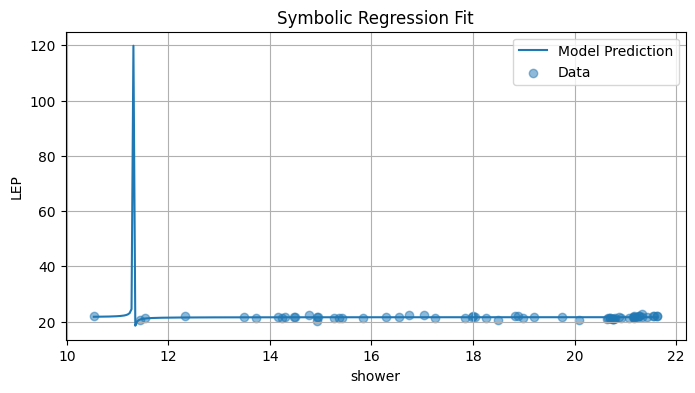

In [171]:
# If X only has 1 feature:
import numpy as np

feature = X.columns[0]
x_vals = np.linspace(X[feature].min(), X[feature].max(), 300)
y_vals = model.predict(pd.DataFrame({feature: x_vals}))

plt.figure(figsize=(8, 4))
plt.plot(x_vals, y_vals, label="Model Prediction")
plt.scatter(X[feature], y, alpha=0.5, label="Data")
plt.xlabel(feature)
plt.ylabel("LEP")
plt.title("Symbolic Regression Fit")
plt.legend()
plt.grid(True)
plt.show()


In [175]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the symbolic equations discovered
equations = model.equations_

# Filter top 9 (by lowest loss or however it's ranked)
top_equations = equations.sort_values("loss").head(9)

# Extract the single feature name
feature = X.columns[0]
x_vals = np.linspace(X[feature].min(), X[feature].max(), 300)
x_df = pd.DataFrame({feature: x_vals})

# Plot each equation
plt.figure(figsize=(18, 12))
for i, row in enumerate(top_equations.itertuples(), 1):
    model.set_params(selected_model=row.Index)  # Set which model to use
    y_vals = model.predict(x_df)

    plt.subplot(3, 3, i)
    plt.scatter(X[feature], y, alpha=0.4, label="Data")
    plt.plot(x_vals, y_vals, color='red', label='Equation')
    plt.title(f"Eq {i}: {row.equation}\nLoss: {row.loss:.4f}, Complexity: {row.complexity}")
    plt.xlabel(feature)
    plt.ylabel("LEP")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


ValueError: Invalid parameter 'selected_model' for estimator PySRRegressor.equations_ = [
	   pick     score  \
	0        0.000000   
	1        0.000915   
	2        0.007235   
	3  >>>>  0.041468   
	4        0.018966   
	
	                                                                      equation  \
	0                                                                    21.547327   
	1                                            21.3903 - (shower * -0.008672267)   
	2                              (-0.5143203 / (shower + -23.524937)) - -21.4128   
	3                 (-1.2609668 / ((shower + -11.314066) * shower)) - -21.582659   
	4  (-1.7982706 / ((shower + -21.931026) * (shower + -11.983385))) - -21.390461   
	
	       loss  complexity  
	0  0.201991           1  
	1  0.201253           5  
	2  0.198362           7  
	3  0.182574           9  
	4  0.175778          11  
]. Valid parameters are: ['adaptive_parsimony_scaling', 'alpha', 'annealing', 'autodiff_backend', 'batch_size', 'batching', 'binary_operators', 'bumper', 'cluster_manager', 'complexity_mapping', 'complexity_of_constants', 'complexity_of_operators', 'complexity_of_variables', 'constraints', 'crossover_probability', 'delete_tempfiles', 'denoise', 'deterministic', 'dimensional_constraint_penalty', 'dimensionless_constants_only', 'early_stop_condition', 'elementwise_loss', 'expression_spec', 'extra_jax_mappings', 'extra_sympy_mappings', 'extra_torch_mappings', 'fast_cycle', 'fraction_replaced', 'fraction_replaced_hof', 'heap_size_hint_in_bytes', 'hof_migration', 'input_stream', 'logger_spec', 'loss_function', 'loss_function_expression', 'max_evals', 'maxdepth', 'maxsize', 'migration', 'model_selection', 'ncycles_per_iteration', 'nested_constraints', 'niterations', 'optimize_probability', 'optimizer_algorithm', 'optimizer_f_calls_limit', 'optimizer_iterations', 'optimizer_nrestarts', 'output_directory', 'output_jax_format', 'output_torch_format', 'parallelism', 'parsimony', 'perturbation_factor', 'population_size', 'populations', 'precision', 'print_precision', 'probability_negate_constant', 'procs', 'progress', 'random_state', 'run_id', 'select_k_features', 'should_optimize_constants', 'should_simplify', 'skip_mutation_failures', 'temp_equation_file', 'tempdir', 'timeout_in_seconds', 'topn', 'tournament_selection_n', 'tournament_selection_p', 'turbo', 'unary_operators', 'update', 'update_verbosity', 'use_frequency', 'use_frequency_in_tournament', 'verbosity', 'warm_start', 'warmup_maxsize_by', 'weight_add_node', 'weight_delete_node', 'weight_do_nothing', 'weight_insert_node', 'weight_mutate_constant', 'weight_mutate_operator', 'weight_optimize', 'weight_randomize', 'weight_rotate_tree', 'weight_simplify', 'weight_swap_operands'].

<Figure size 1800x1200 with 0 Axes>